## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import re
import gc
import copy

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import nltk.data

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
from transformers import RobertaTokenizer
import transformers

from text_data import TextDataset5 as TextDataset
from roberta import CustomRoberta
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np, optimize_rounding_params, get_cvs, spearmanr
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv')
train = pd.read_csv(f'{path}train.csv')

In [3]:
%%time
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
seg_ids_train, ids_train = {}, {}
seg_ids_test, ids_test = {}, {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text, cols in [('question', ['question_title', 'question_body']), 
                       ('answer', ['question_title', 'answer'])]:
        ids, seg_ids, sent_ids = [], [], []
        for x1, x2 in tqdm(df[cols].values):
            encoded_inputs = tokenizer.encode_plus(
                x1, x2, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True, 
                return_token_type_ids=True
            )
            ids.append(encoded_inputs['input_ids'])
            seg_ids.append(encoded_inputs['token_type_ids'])
        if mode == 'train': 
            ids_train[text] = np.array(ids)
            seg_ids_train[text] = np.array(seg_ids)
        else: 
            ids_test[text] = np.array(ids)
            seg_ids_test[text] = np.array(seg_ids)


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



CPU times: user 14 s, sys: 163 ms, total: 14.1 s
Wall time: 14.9 s


In [4]:
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [5]:
cat_features_train = train_category.reshape(-1, 1)
cat_features_test = test_category.reshape(-1, 1)
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)
ix = np.where(train.groupby("question_body")["host"].transform("count") == 1)[0]

In [7]:
num_workers = 10
bs = 2

In [8]:
bs_test = 2
test_loader = DataLoader(
    TextDataset(cat_features_test, ids_test['question'], ids_test['answer'], 
                seg_ids_test['question'], seg_ids_test['answer'], test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers, drop_last=False
)

## Training model

In [9]:
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 4
grad_accum = 4

weight_decay = 0.01
model_name = 'siamese_roberta_2'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10

In [10]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters

def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.roberta, lr / 100, weight_decay)
    )

Fold 1 started at Wed Feb  5 07:49:30 2020


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


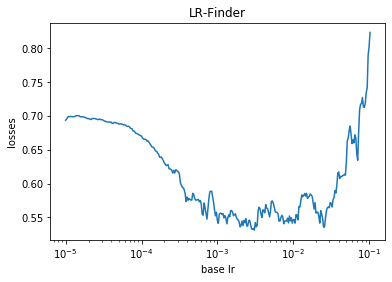

epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.52694 - spearmanr 0.18034
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.49399 - spearmanr 0.35063


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


best model: epoch 0 - 0.35063
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.4705 - spearmanr 0.35249
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46006 - spearmanr 0.40907
best model: epoch 1 - 0.40907
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.44911 - spearmanr 0.41338
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45019 - spearmanr 0.41841
best model: epoch 2 - 0.41841
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.43406 - spearmanr 0.45487
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.44854 - spearmanr 0.42124
best model: epoch 3 - 0.42124
TRAINING END: Best score achieved on epoch 3 - 0.42124
Starting inference for model: checkpoints/siamese_roberta_2_fold_1_best.pth



Averaged Val. score: 0.4212416651867092
Starting inference for model: checkpoints/siamese_roberta_2_fold_1_best.pth



Fold 2 started at Wed Feb  5 08:29:53 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.52696 - spearmanr 0.17566
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.48881 - spearmanr 0.34103
best model: epoch 0 - 0.34103
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.47213 - spearmanr 0.34589
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46298 - spearmanr 0.39787
best model: epoch 1 - 0.39787
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.45058 - spearmanr 0.40756
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45473 - spearmanr 0.41783
best model: epoch 2 - 0.41783
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.43512 - spearmanr 0.44925
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45249 - spearmanr 0.41811
best model: epoch 3 - 0.41811
TRAINING END: Best score achieved on epoch 3 - 0.41811
Starting inference for model: checkpoints/siamese_roberta_2_fold_2_best.pth



Averaged Val. score: 0.41811461195427974
Starting inference for model: checkpoints/siamese_roberta_2_fold_2_best.pth



Fold 3 started at Wed Feb  5 09:08:58 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.52962 - spearmanr 0.16101
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.48998 - spearmanr 0.30145
best model: epoch 0 - 0.30145
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.47302 - spearmanr 0.34317
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46045 - spearmanr 0.39353
best model: epoch 1 - 0.39353
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.45007 - spearmanr 0.40905
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45549 - spearmanr 0.40918
best model: epoch 2 - 0.40918
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.43485 - spearmanr 0.45199
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45297 - spearmanr 0.41058
best model: epoch 3 - 0.41058
TRAINING END: Best score achieved on epoch 3 - 0.41058
Starting inference for model: checkpoints/siamese_roberta_2_fold_3_best.pth



Averaged Val. score: 0.4105763882547571
Starting inference for model: checkpoints/siamese_roberta_2_fold_3_best.pth



Fold 4 started at Wed Feb  5 09:48:02 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.52765 - spearmanr 0.17628
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.48376 - spearmanr 0.32327
best model: epoch 0 - 0.32327
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.47041 - spearmanr 0.35166
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46163 - spearmanr 0.38104
best model: epoch 1 - 0.38104
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.44835 - spearmanr 0.41447
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45397 - spearmanr 0.40183
best model: epoch 2 - 0.40183
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.43353 - spearmanr 0.45595
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45152 - spearmanr 0.40342
best model: epoch 3 - 0.40342
TRAINING END: Best score achieved on epoch 3 - 0.40342
Starting inference for model: checkpoints/siamese_roberta_2_fold_4_best.pth



Averaged Val. score: 0.40341527812463873
Starting inference for model: checkpoints/siamese_roberta_2_fold_4_best.pth



Fold 5 started at Wed Feb  5 10:27:07 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.52683 - spearmanr 0.18058
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47717 - spearmanr 0.33407
best model: epoch 0 - 0.33407
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.47041 - spearmanr 0.35334
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45496 - spearmanr 0.39303
best model: epoch 1 - 0.39303
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.44835 - spearmanr 0.41543
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45027 - spearmanr 0.40678
best model: epoch 2 - 0.40678
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.43349 - spearmanr 0.45747
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.44767 - spearmanr 0.40896
best model: epoch 3 - 0.40896
TRAINING END: Best score achieved on epoch 3 - 0.40896
Starting inference for model: checkpoints/siamese_roberta_2_fold_5_best.pth



Averaged Val. score: 0.4089635349905087
Starting inference for model: checkpoints/siamese_roberta_2_fold_5_best.pth



Fold 6 started at Wed Feb  5 11:06:12 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.53033 - spearmanr 0.16549
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47929 - spearmanr 0.33333
best model: epoch 0 - 0.33333
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.47032 - spearmanr 0.35465
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45221 - spearmanr 0.39122
best model: epoch 1 - 0.39122
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.44899 - spearmanr 0.41391
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.44697 - spearmanr 0.40175
best model: epoch 2 - 0.40175
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.43342 - spearmanr 0.4571
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.44484 - spearmanr 0.40702
best model: epoch 3 - 0.40702
TRAINING END: Best score achieved on epoch 3 - 0.40702
Starting inference for model: checkpoints/siamese_roberta_2_fold_6_best.pth



Averaged Val. score: 0.4070173664209966
Starting inference for model: checkpoints/siamese_roberta_2_fold_6_best.pth



Fold 7 started at Wed Feb  5 11:45:20 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.52979 - spearmanr 0.16011
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.49353 - spearmanr 0.31018
best model: epoch 0 - 0.31018
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.47408 - spearmanr 0.34229
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46362 - spearmanr 0.39384
best model: epoch 1 - 0.39384
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.45014 - spearmanr 0.4096
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45507 - spearmanr 0.41503
best model: epoch 2 - 0.41503
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.4351 - spearmanr 0.45072
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45271 - spearmanr 0.41873
best model: epoch 3 - 0.41873
TRAINING END: Best score achieved on epoch 3 - 0.41873
Starting inference for model: checkpoints/siamese_roberta_2_fold_7_best.pth



Averaged Val. score: 0.41872673136752925
Starting inference for model: checkpoints/siamese_roberta_2_fold_7_best.pth



Fold 8 started at Wed Feb  5 12:24:24 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.52879 - spearmanr 0.16704
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.49795 - spearmanr 0.32123
best model: epoch 0 - 0.32123
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.47158 - spearmanr 0.34521
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46692 - spearmanr 0.39722
best model: epoch 1 - 0.39722
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.44975 - spearmanr 0.40647
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45741 - spearmanr 0.41926
best model: epoch 2 - 0.41926
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.43443 - spearmanr 0.44981
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45481 - spearmanr 0.42384
best model: epoch 3 - 0.42384
TRAINING END: Best score achieved on epoch 3 - 0.42384
Starting inference for model: checkpoints/siamese_roberta_2_fold_8_best.pth



Averaged Val. score: 0.4238356938921754
Starting inference for model: checkpoints/siamese_roberta_2_fold_8_best.pth



Fold 9 started at Wed Feb  5 13:03:28 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.52667 - spearmanr 0.17735
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.48464 - spearmanr 0.33028
best model: epoch 0 - 0.33028
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.47019 - spearmanr 0.35346
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.4583 - spearmanr 0.39536
best model: epoch 1 - 0.39536
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.44926 - spearmanr 0.41087
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45407 - spearmanr 0.40316
best model: epoch 2 - 0.40316
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.4344 - spearmanr 0.45414
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45003 - spearmanr 0.40969
best model: epoch 3 - 0.40969
TRAINING END: Best score achieved on epoch 3 - 0.40969
Starting inference for model: checkpoints/siamese_roberta_2_fold_9_best.pth



Averaged Val. score: 0.4096925557125037
Starting inference for model: checkpoints/siamese_roberta_2_fold_9_best.pth



Fold 10 started at Wed Feb  5 13:42:33 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.52838 - spearmanr 0.17183
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.48098 - spearmanr 0.33511
best model: epoch 0 - 0.33511
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.47255 - spearmanr 0.34805
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45391 - spearmanr 0.406
best model: epoch 1 - 0.406
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.45076 - spearmanr 0.40911
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.44335 - spearmanr 0.41995
best model: epoch 2 - 0.41995
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.43557 - spearmanr 0.45069
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.44181 - spearmanr 0.42211
best model: epoch 3 - 0.42211
TRAINING END: Best score achieved on epoch 3 - 0.42211
Starting inference for model: checkpoints/siamese_roberta_2_fold_10_best.pth



Averaged Val. score: 0.4221073812878297
Starting inference for model: checkpoints/siamese_roberta_2_fold_10_best.pth



OOF score: 0.41473420760606333


In [11]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    model = CustomRoberta(256, cat_features_train.shape[1], head_dropout=0.5)
    
    if fold_id == 0:
#         print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    if (fold_id + 1) > 0: learner.train()
        
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    print(f'Averaged Val. score: {spearmanr_np(oofs[valid_index], y[valid_index])}')
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / n_folds
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')

In [12]:
opt_ds, opt_indices = optimize_rounding_params(oofs, y)

2 4 0.4952289791585956
5 4 0.4632950693596898
9 64 0.11479372733276554
11 8 0.7522142764333442
12 4 0.5647623559438028
13 4 0.2765316367716797
14 4 0.641862256350403
15 4 0.5804475501265874
16 8 0.7858451733565861
19 64 0.10103058613395377
23 16 0.16548447041038908


In [13]:
np.array(opt_ds), np.array(opt_indices)

(array([ 4,  4, 64,  8,  4,  4,  4,  4,  8, 64, 16]),
 array([ 2,  5,  9, 11, 12, 13, 14, 15, 16, 19, 23]))

In [14]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0

In [15]:
get_cvs(oofs, y, ix)

,SpearmanR
CV,0.414734
CV unique rows,0.382140
CV ignoring hard targets,0.439043
CV unique rows ignoring hard targets,0.403958
CV w rounding,0.444556
CV unique rows w rounding,0.418640
CV ignoring hard targets w rounding,0.468602
CV unique rows ignoring hard targets w rounding,0.441676


In [16]:
get_cvs(oofs_alt, y, ix)

,SpearmanR
CV,0.418842
CV unique rows,0.386195
CV ignoring hard targets,0.439043
CV unique rows ignoring hard targets,0.403958
CV w rounding,0.447331
CV unique rows w rounding,0.422694
CV ignoring hard targets w rounding,0.468602
CV unique rows ignoring hard targets w rounding,0.441676


In [17]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [18]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.814931,0.544051,0.550322,0.389551,0.336084,0.257918,0.699499,0.752388,0.722264,0.008758,0.846709,0.772019,0.065640,0.409251,0.011615,0.013315,0.067802,0.169417,0.753274,0.001696,0.813538,0.662895,0.299323,0.791386,0.811726,0.442682,0.036656,0.070822,0.775101,0.706736
1,46,0.513964,0.296518,0.010587,0.661585,0.678946,0.866832,0.390526,0.266981,0.190758,0.009553,0.476402,0.446960,0.006914,0.002752,0.002500,0.014422,0.831886,0.350822,0.200664,0.000459,0.384731,0.719593,0.472850,0.815371,0.854156,0.511499,0.830360,0.307900,0.224351,0.627049
2,70,0.728709,0.600029,0.058524,0.703447,0.816567,0.866195,0.538893,0.453642,0.327697,0.009291,0.273207,0.765454,0.045562,0.129594,0.008591,0.020743,0.165342,0.165761,0.635851,0.002319,0.739230,0.654342,0.323852,0.784444,0.745638,0.477665,0.087409,0.102788,0.753100,0.628011
3,132,0.577844,0.275485,0.010551,0.608127,0.661379,0.824766,0.417232,0.270322,0.202613,0.015531,0.552512,0.072945,0.004119,0.003874,0.001743,0.011748,0.807169,0.310370,0.604316,0.000233,0.446366,0.746953,0.538532,0.846155,0.867011,0.578603,0.810707,0.313366,0.581641,0.610520
4,200,0.761160,0.342617,0.097045,0.703496,0.707043,0.776173,0.616697,0.635489,0.395857,0.013582,0.464187,0.739459,0.043825,0.071046,0.009477,0.029410,0.194038,0.190943,0.626680,0.003103,0.574086,0.756679,0.527442,0.866344,0.863820,0.601757,0.301820,0.214927,0.706340,0.674854


In [19]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [20]:
pd.DataFrame(oofs, columns=TARGETS)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0.853693,0.651189,0.294507,0.612570,0.564979,0.341405,0.642997,0.600475,0.249426,0.005098,0.697562,0.126240,0.461039,0.038137,0.030969,0.259697,0.219435,0.134859,0.477101,0.004038,0.809170,0.854400,0.569710,0.934769,0.923152,0.695014,0.126448,0.091414,0.828072,0.792667
1,0.880021,0.839747,0.037483,0.529346,0.945249,0.666649,0.600459,0.739686,0.382702,0.002261,0.174629,0.071719,0.662953,0.005801,0.841683,0.070781,0.032584,0.060324,0.333199,0.004549,0.827778,0.497358,0.270765,0.695790,0.790300,0.332764,0.020725,0.029775,0.306764,0.766598
2,0.625604,0.356591,0.013075,0.634792,0.784362,0.835204,0.460855,0.278654,0.213752,0.003792,0.361129,0.108082,0.007016,0.003278,0.003169,0.119757,0.749911,0.361947,0.241003,0.000348,0.569750,0.864829,0.612993,0.924234,0.926072,0.698599,0.720194,0.337787,0.537959,0.775824
3,0.850741,0.761553,0.080696,0.785361,0.901513,0.861662,0.606287,0.634424,0.452457,0.001228,0.150108,0.934116,0.023965,0.016409,0.101893,0.084898,0.025484,0.094157,0.443644,0.004883,0.851860,0.718866,0.604913,0.782008,0.837391,0.652704,0.050204,0.082394,0.695230,0.664629
4,0.792899,0.778340,0.008439,0.665446,0.805306,0.881349,0.537653,0.471101,0.214373,0.001009,0.340734,0.483131,0.004537,0.002601,0.000978,0.008287,0.816294,0.342913,0.127995,0.000133,0.818922,0.650759,0.348961,0.769023,0.789527,0.446678,0.841192,0.254655,0.057869,0.596076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,0.849507,0.580284,0.245086,0.729025,0.528728,0.481422,0.628543,0.571908,0.661999,0.005356,0.755004,0.913519,0.115630,0.220574,0.017019,0.076311,0.097183,0.147558,0.519732,0.002214,0.810073,0.845679,0.637103,0.916749,0.915051,0.645530,0.133844,0.141511,0.803285,0.764734
6075,0.798614,0.480838,0.149630,0.546564,0.470615,0.444345,0.646786,0.626376,0.135194,0.011978,0.733835,0.087320,0.031625,0.008616,0.004526,0.044230,0.758543,0.459260,0.165128,0.001224,0.724315,0.855847,0.590460,0.910859,0.911768,0.653846,0.804423,0.406991,0.401648,0.823438
6076,0.608736,0.371555,0.015145,0.661115,0.715914,0.837268,0.433793,0.325741,0.247444,0.008498,0.439985,0.569231,0.008552,0.008082,0.003749,0.021002,0.793599,0.378390,0.220390,0.000858,0.510005,0.639431,0.385054,0.790070,0.800860,0.448216,0.635343,0.240450,0.584046,0.571052
6077,0.802746,0.605966,0.579010,0.484997,0.452544,0.320159,0.623531,0.719365,0.421012,0.008812,0.769298,0.758538,0.186906,0.099550,0.057232,0.041692,0.034432,0.144206,0.688804,0.004998,0.801041,0.764464,0.661081,0.842100,0.887684,0.660428,0.014089,0.109520,0.884395,0.782589


In [21]:
rs = pd.Series({col: spearmanr(oofs[:,i], y[:,i])[0] for i, col in enumerate(TARGETS)})
rs

question_asker_intent_understanding      0.391260
question_body_critical                   0.606104
question_conversational                  0.416342
question_expect_short_answer             0.311905
question_fact_seeking                    0.370526
question_has_commonly_accepted_answer    0.434739
question_interestingness_others          0.367793
question_interestingness_self            0.512427
question_multi_intent                    0.568846
question_not_really_a_question           0.087786
question_opinion_seeking                 0.484725
question_type_choice                     0.740696
question_type_compare                    0.364506
question_type_consequence                0.178389
question_type_definition                 0.364215
question_type_entity                     0.454488
question_type_instructions               0.781218
question_type_procedure                  0.374285
question_type_reason_explanation         0.673596
question_type_spelling                   0.061034


In [22]:
rs_df = pd.DataFrame(np.vstack([rs.values.flatten(), train[TARGETS].nunique()]).T, 
                     columns=['SpearmanCorr', 'NUnique'], index=rs.index)
rs_df.sort_values('SpearmanCorr', ascending=True)

,SpearmanCorr,NUnique
question_type_spelling,0.061034,3.0
question_not_really_a_question,0.087786,5.0
answer_plausible,0.163431,9.0
question_type_consequence,0.178389,5.0
answer_relevance,0.180111,9.0
answer_well_written,0.206358,9.0
answer_helpful,0.253092,9.0
question_expect_short_answer,0.311905,5.0
answer_type_procedure,0.316512,5.0
answer_satisfaction,0.353642,17.0


In [23]:
sorted_targets = rs_df.sort_values('SpearmanCorr', ascending=True).index
worst_five_targets = sorted_targets[:5]
worst_five_targets

Index(['question_type_spelling', 'question_not_really_a_question',
       'answer_plausible', 'question_type_consequence', 'answer_relevance'],
      dtype='object')

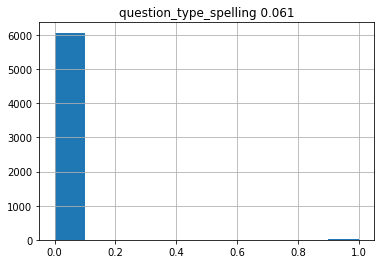

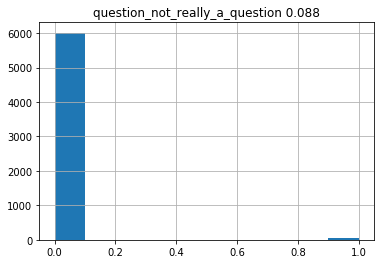

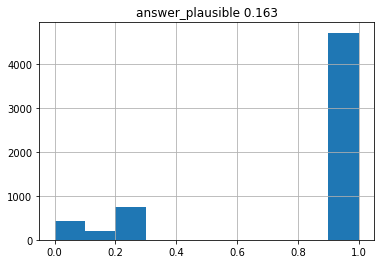

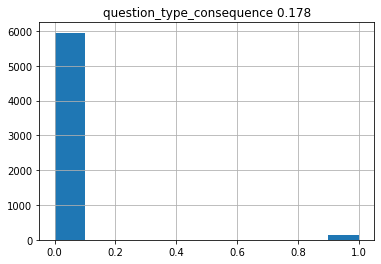

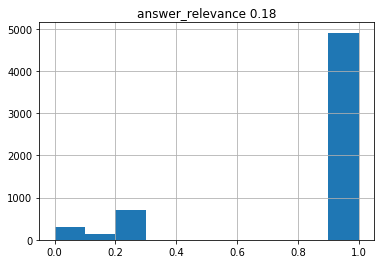

In [24]:
for col in worst_five_targets:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


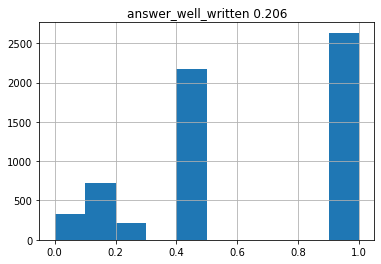

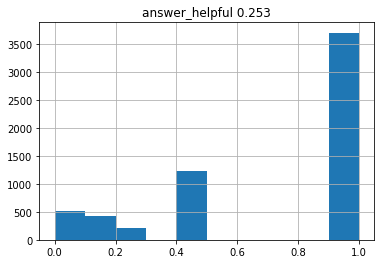

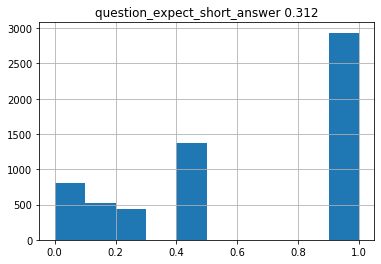

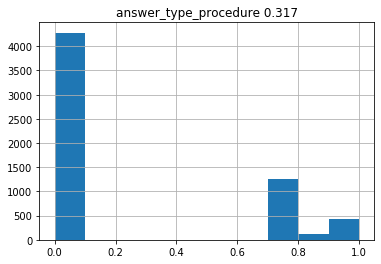

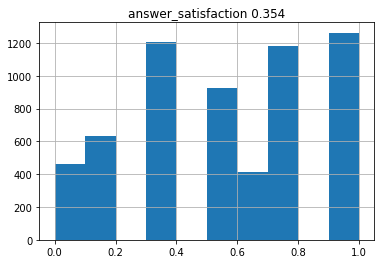

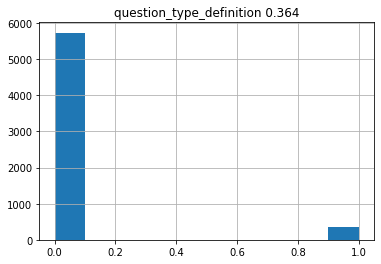

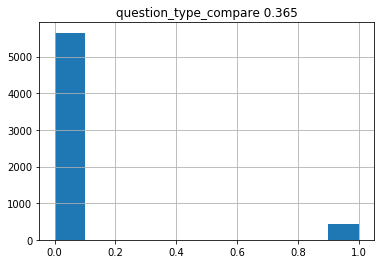

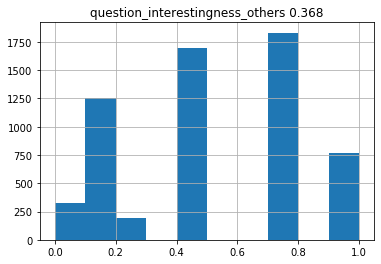

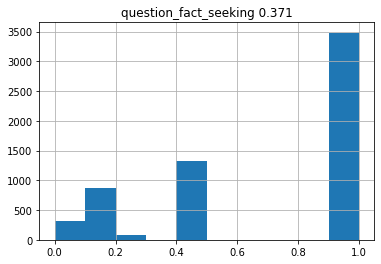

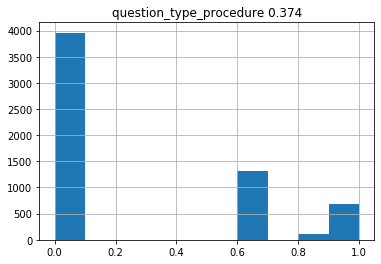

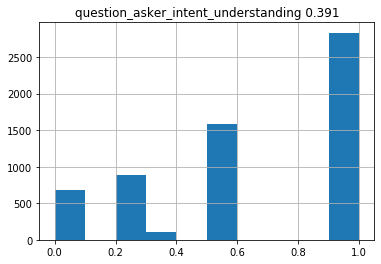

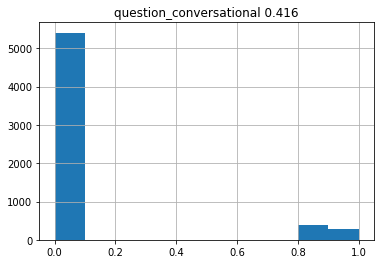

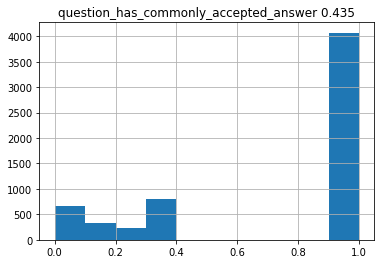

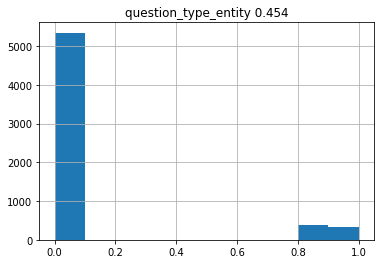

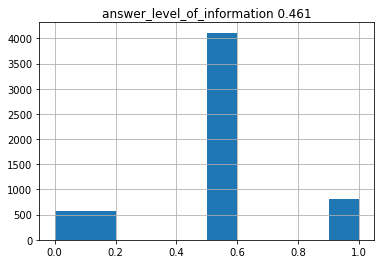

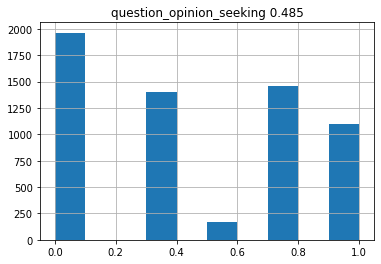

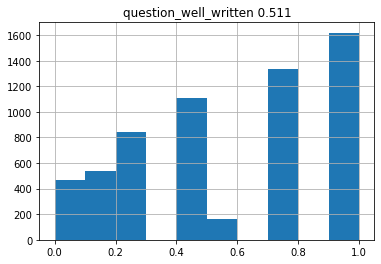

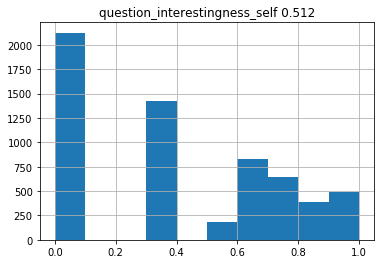

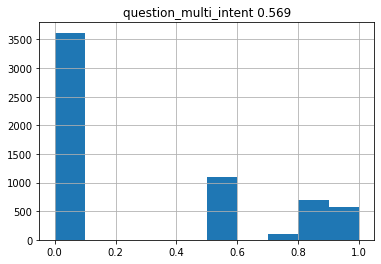

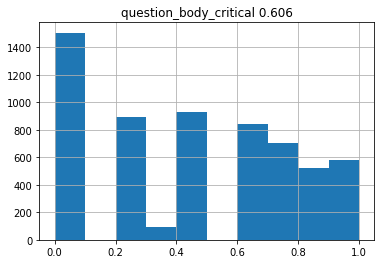

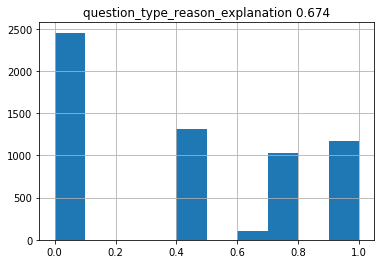

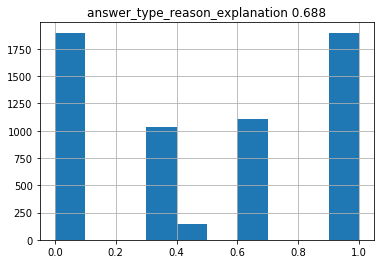

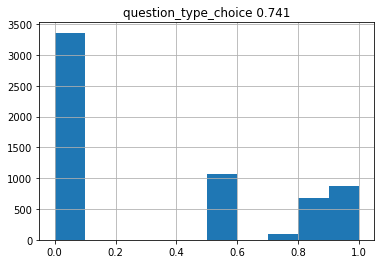

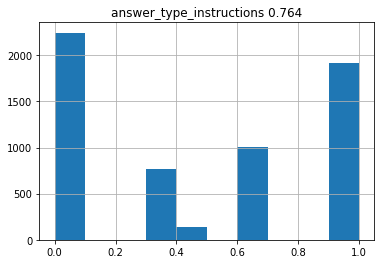

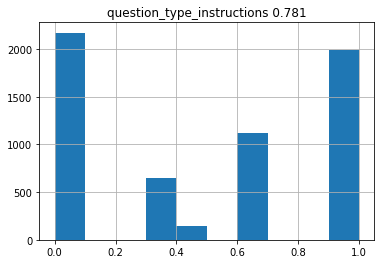

In [25]:
for col in [target for target in sorted_targets if target not in worst_five_targets]:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')